In [1]:
# %%
"""
04_objects.ipynb – detekcja obiektów YOLO w obrazach z katalogu data/staging.
"""

from pathlib import Path
from datetime import datetime, timezone
import time
import json

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from ultralytics import YOLO

In [2]:
# %%
"""
Ustawienia urządzenia (device) i ścieżek projektu.
"""

def get_device() -> torch.device:
    """
    Wybiera urządzenie obliczeniowe.

    Preferencja: MPS → CUDA → CPU.
    """
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def device_to_yolo(device: torch.device) -> str:
    """
    Zamienia torch.device na format akceptowany przez YOLO (Ultralytics).

    device – torch.device, np. mps/cuda/cpu
    """
    if device.type == "cuda":
        return "0"  # pierwsza karta GPU
    return device.type  # "mps" lub "cpu"


device = get_device()
print("Device:", device)

PROJECT_ROOT = Path(".").resolve()
DIR_DATA = PROJECT_ROOT / "data"
DIR_STAGING = DIR_DATA / "staging"
DIR_OUT = PROJECT_ROOT / "outputs"
DIR_OUT.mkdir(parents=True, exist_ok=True)

CSV_PATH = DIR_OUT / "objects_detection.csv"

LOGS_DIR = PROJECT_ROOT / "logs"
LOGS_DIR.mkdir(parents=True, exist_ok=True)
RUNLOG_PATH = LOGS_DIR / "runlog.jsonl"

print("Wejście (obrazy):", DIR_STAGING)
print("Wyjście (CSV):   ", CSV_PATH)

Device: mps
Wejście (obrazy): /Users/olga/MetaLogic/data/staging
Wyjście (CSV):    /Users/olga/MetaLogic/outputs/objects_detection.csv


In [3]:
# %%
"""
Ładowanie modelu YOLO z biblioteki ultralytics.

Na razie używamy lekkiego modelu bazowego (COCO),
docelowo możesz tu podstawić własny model wytrenowany na PRL.
"""

MODEL_PATH = "yolov8n.pt"  # nazwa pliku / wariantu modelu

def load_yolo_model(model_path: str, device: torch.device) -> YOLO:
    """
    Ładuje model YOLO (Ultralytics) na wybrane urządzenie.

    model_path – ścieżka lub alias modelu (np. "yolov8n.pt")
    device     – torch.device (mps/cuda/cpu)
    """
    model = YOLO(model_path)
    # przypisanie urządzenia w wywołaniu, nie wymaga .to()
    print(f"Załadowano model: {model_path}")
    return model


yolo_model = load_yolo_model(MODEL_PATH, device)
YOLO_DEVICE = device_to_yolo(device)
print("YOLO device string:", YOLO_DEVICE)

Załadowano model: yolov8n.pt
YOLO device string: mps


In [4]:
# %%
"""
Funkcje pomocnicze: listowanie obrazów i pojedyncza detekcja YOLO.
"""

def list_images(root: Path):
    """
    Zwraca listę ścieżek do obrazów (jpg/jpeg/png/tif/tiff) w katalogu root (rekurencyjnie).

    root – katalog startowy (Path)
    """
    exts = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
    return [p for p in root.rglob("*") if p.suffix.lower() in exts]


def load_image(path: Path) -> Image.Image:
    """
    Wczytuje obraz jako obiekt PIL.Image w trybie RGB.

    path – ścieżka do pliku graficznego
    """
    img = Image.open(path)
    return img.convert("RGB")


def detect_objects_on_image(
    path: Path,
    model: YOLO,
    device_str: str,
    conf_thr: float = 0.25,
):
    """
    Wykrywa obiekty YOLO na pojedynczym obrazie.

    path      – ścieżka do pliku obrazu
    model     – obiekt YOLO (Ultralytics)
    device_str – urządzenie w formacie YOLO, np. "mps", "cpu", "0"
    conf_thr  – minimalny próg pewności detekcji (0–1)
    """
    results = model(
        str(path),
        device=device_str,
        conf=conf_thr,
        verbose=False,
    )[0]

    boxes = results.boxes
    h, w = results.orig_shape
    records = []

    for box in boxes:
        xyxy = box.xyxy[0].tolist()
        x1, y1, x2, y2 = map(float, xyxy)
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])
        cls_name = results.names[cls_id]

        records.append(
            {
                "file_path": str(path.relative_to(PROJECT_ROOT)),
                "width": w,
                "height": h,
                "class_id": cls_id,
                "class_name": cls_name,
                "confidence": conf,
                "x1": x1,
                "y1": y1,
                "x2": x2,
                "y2": y2,
            }
        )

    return records

In [ ]:
# %%
"""
Główna pętla: detekcja obiektów we wszystkich obrazach katalogu wejściowego.
"""

IN_DIR = DIR_STAGING / "test_scenes"
CONF_THR = 0.25       # próg pewności detekcji

image_paths = list_images(IN_DIR)
print("Liczba znalezionych obrazów:", len(image_paths))

all_records = []
t0 = time.time()

for path in image_paths:
    recs = detect_objects_on_image(
        path=path,
        model=yolo_model,
        device_str=YOLO_DEVICE,
        conf_thr=CONF_THR,
    )
    all_records.extend(recs)

dt = time.time() - t0
if len(image_paths) > 0:
    print(f"Przetworzono {len(image_paths)} obrazów w {dt:.1f} s ({len(image_paths) / dt:.2f} img/s).")
print("Liczba wykrytych obiektów:", len(all_records))

df_objects = pd.DataFrame(all_records)
df_objects.head()

Liczba znalezionych obrazów: 100
Przetworzono 100 obrazów w 21.0 s (4.76 img/s).
Liczba wykrytych obiektów: 786


,file_path,width,height,class_id,class_name,confidence,x1,y1,x2,y2
0,data/staging/20251112_132024_A1/0138.jpg,1164,1500,74,clock,0.455210,263.725067,657.043335,328.846252,718.058533
1,data/staging/20251112_132024_A1/0106.jpg,2000,1545,0,person,0.907012,821.484985,84.125519,1689.927490,1202.084229
2,data/staging/20251112_132024_A1/0106.jpg,2000,1545,0,person,0.662205,118.496468,592.623840,253.969864,1052.413818
3,data/staging/20251112_132024_A1/0106.jpg,2000,1545,54,donut,0.641631,773.398376,1142.404541,1063.138062,1253.623413
4,data/staging/20251112_132024_A1/0106.jpg,2000,1545,54,donut,0.603025,378.382538,1264.303101,770.735168,1435.407104


In [6]:
# %%
"""
Zapis wyników detekcji do CSV oraz logu runlog.jsonl.
"""

timestamp = datetime.now(timezone.utc).isoformat()
df_objects["timestamp"] = timestamp

df_objects.to_csv(CSV_PATH, index=False)
print("Zapisano wyniki do:", CSV_PATH)

runlog_entry = {
    "timestamp": timestamp,
    "step": "objects_yolo",
    "n_images": int(len(image_paths)),
    "n_detections": int(len(df_objects)),
    "csv_path": str(CSV_PATH),
    "model_path": MODEL_PATH,
    "device": str(device),
    "conf_thr": CONF_THR,
}

with RUNLOG_PATH.open("a", encoding="utf-8") as f:
    f.write(json.dumps(runlog_entry, ensure_ascii=False) + "\n")

print("Dopisano wpis do:", RUNLOG_PATH)

Zapisano wyniki do: /Users/olga/MetaLogic/outputs/objects_detection.csv
Dopisano wpis do: /Users/olga/MetaLogic/logs/runlog.jsonl


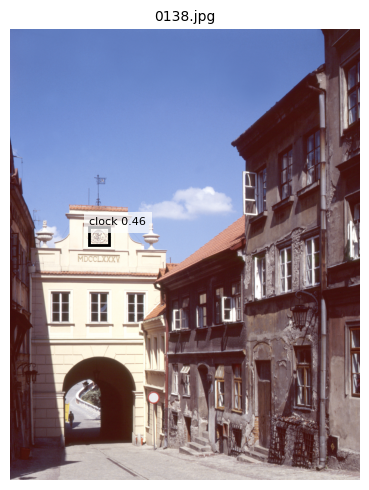

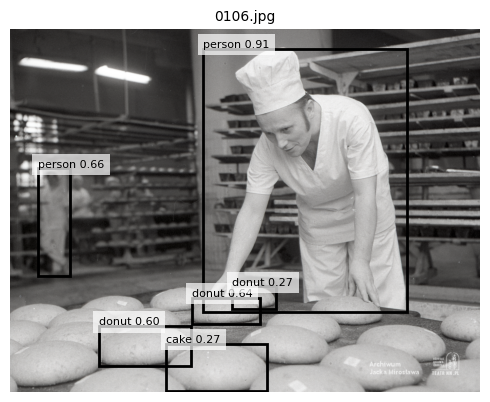

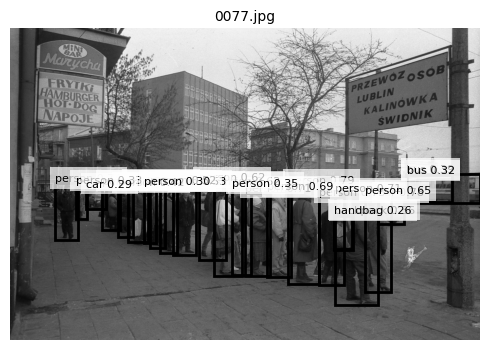

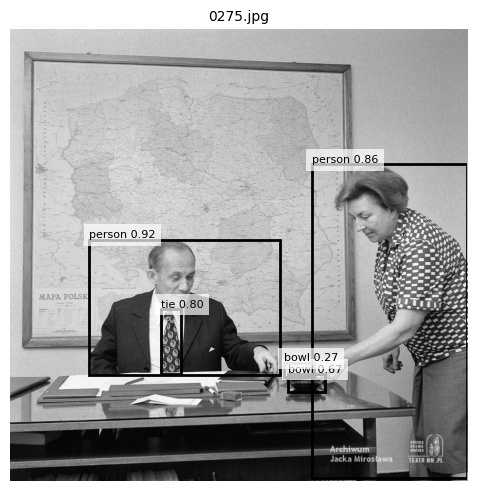

In [7]:
# %%
"""
Podgląd kilku obrazów z nałożonymi bounding boxami.
"""

N_IMAGES_PREVIEW = 4  # maksymalna liczba obrazów w podglądzie


def plot_detections_for_image(
    path: Path,
    df_det: pd.DataFrame,
    project_root: Path,
):
    """
    Rysuje pojedynczy obraz z nałożonymi bounding boxami YOLO.

    path       – ścieżka do obrazu (Path)
    df_det     – DataFrame z detekcjami (subset dla danego pliku)
    project_root – katalog bazowy repozytorium
    """
    img = load_image(path)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    ax.axis("off")

    for _, row in df_det.iterrows():
        x1, y1, x2, y2 = row["x1"], row["y1"], row["x2"], row["y2"]
        cls_name = row["class_name"]
        conf = row["confidence"]

        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(
            x1,
            max(y1 - 5, 0),
            f"{cls_name} {conf:.2f}",
            fontsize=8,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

    ax.set_title(path.name, fontsize=10)
    plt.tight_layout()
    plt.show()


# wybieramy podgląd tylko dla obrazów, które mają detekcje
if not df_objects.empty:
    files_with_dets = df_objects["file_path"].unique()[:N_IMAGES_PREVIEW]

    for rel_path in files_with_dets:
        img_path = PROJECT_ROOT / rel_path
        df_subset = df_objects[df_objects["file_path"] == rel_path]
        plot_detections_for_image(img_path, df_subset, PROJECT_ROOT)
else:
    print("Brak detekcji do wyświetlenia.")